In [90]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
import json
import subprocess
import re

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

from keras import models, layers
from keras.preprocessing import image

### Load Movies DataSet

In [83]:
movies = pd.read_csv('./data/tmdb_5000_movies.csv')
credits = pd.read_csv('./data/tmdb_5000_credits.csv')

### Create Label For Samuel

We should move pretty much all of this to another file as it is redundant

In [88]:
movies = pd.merge(left=movies, right=credits, left_on='id', right_on='movie_id')

In [91]:
# turn json into python objects
json_columns = ['genres', 'keywords', 'production_countries', 'spoken_languages', 'cast', 'crew']
for column in json_columns:
    movies[column] = movies[column].apply(json.loads, encoding="utf-8")

In [92]:
def actor_to_id_string(actor):
    return '{} - {}'.format(actor['name'], actor['id'])

In [93]:
def cast_to_actors(cast):
    actors = []
    for person in cast:
        actors.append(actor_to_id_string(person))
    return actors

In [94]:
movies.actors = movies.cast.apply(cast_to_actors)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [95]:
all_actors = []
for actors in movies.actors:
    for actor in actors:
        all_actors.append(actor)

In [96]:
actors = pd.Series(all_actors)

In [97]:
def get_actor_feature_name(id):
    return actors_string_id_by_id[id] + ' (actor)'

In [98]:
unique_actors_count = pd.crosstab(actors, columns='count')

unique_actors_count \
.sort_values(by='count', ascending=False).head(12)

col_0,count
row_0,
Samuel L. Jackson - 2231,67
Robert De Niro - 380,57
Bruce Willis - 62,51
Matt Damon - 1892,48
Morgan Freeman - 192,46
Steve Buscemi - 884,43
Liam Neeson - 3896,41
Johnny Depp - 85,40
Owen Wilson - 887,40


In [99]:
actors_string_id_by_id = {}
actor_counts_by_string_id = {}
unique_actors_count_dict = unique_actors_count.to_dict()['count']

def actor_has_more_than_x_movies(actor, number_of_movies = 3):
    string_id = str(actor['id'])

    # First, get the unique id created for the actor
    actor_string_id = ''
    if string_id in actors_string_id_by_id:
        actor_string_id = actors_string_id_by_id[string_id]
    else:
        actor_string_id = actor_to_id_string(actor)
        actors_string_id_by_id[string_id] = actor_string_id
    
    # Now let's see how many movies this actor has played in
    actor_count = unique_actors_count_dict[actor_string_id]
    return actor_count > number_of_movies

In [100]:
movies_actors_ids = []
for actors in movies.cast:
    movie_actors_ids = []
    for actor in actors:
        if (not actor_has_more_than_x_movies(actor, 3)):
            continue
        movie_actors_ids.append(str(actor['id']))
    movies_actors_ids.append(' '.join(movie_actors_ids))

In [101]:
vectorizer = CountVectorizer()

movie_vector = vectorizer.fit_transform(movies_actors_ids).toarray()

actor_feature_ids = vectorizer.get_feature_names()
actor_feature_names = []
for id in actor_feature_ids:
    actor_name = get_actor_feature_name(id)
    actor_feature_names.append(actor_name)
    
actor_vector_works = pd.DataFrame(movie_vector, columns=actor_feature_names)
actor_vector_works['id'] = movies.id

In [102]:
movies['samuel'] = actor_vector_works[get_actor_feature_name('2231')] == 1

### Read Posters Directory

In [5]:
posters_dir = 'data/posters'
poster_filenames = os.listdir(posters_dir)

### Create Series Of Movie Ids from Files

In [52]:
def get_movie_id_from_filename(filename):
    movie_id = filename.split('.')[0]
    return movie_id

In [67]:
file_movie_ids = []

for filename in poster_filenames:
    movie_id = get_movie_id_from_filename(filename)
    file_movie_ids.append(movie_id)

### Load a few images

In [53]:
posters_by_movie_id = {}
LIMIT = 10

def load_images():
    i = 0
    for filename in poster_filenames:
        i += 1
        if i is LIMIT:
            break
        movie_id = get_movie_id_from_filename(filename)
        img_path = os.path.join(posters_dir, filename)

        posters_by_movie_id[movie_id] = image.load_img(img_path)
%time load_images()

CPU times: user 749 µs, sys: 304 µs, total: 1.05 ms
Wall time: 1.06 ms


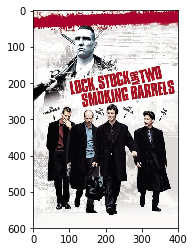

In [54]:
plt.imshow(posters_by_movie_id['100'])

### Verify dimensions of all images

Only necessary for sanity check - about 10% of images do not have 600 pixels height but are all very close (farthest I could tell is around 560px)

In [50]:
EXPECTED_DIMENSION = '400x600'
def check_dimension(dimension):
    return dimension == EXPECTED_DIMENSION

def check_incorrect_dimensions():
    incorrect_dimensions = []

    for filename in poster_filenames:
        img_path = os.path.join(posters_dir, filename)
        output = subprocess.check_output(["file", img_path]).decode('utf-8')
        dimension = re.search('\d{3,4}x\d{3,4}', output)[0]
        if check_dimension(dimension) is False:
            incorrect_dimensions.append({ filename: dimension })
    return pd.Series(incorrect_dimensions)

# print(check_incorrect_dimensions())

### Check movies with missing posters

In [103]:
ids = movies.id.tolist()
missing_movies = []
for id in ids:
    if not str(id) in file_movie_ids:
        missing_movies.append(id)
movies[movies.id.isin(missing_movies)]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew,samuel
2631,0,"[{'id': 18, 'name': 'Drama'}]",NaN,112430,"[{'id': 11162, 'name': 'miniseries'}]",en,The Company,Real-life figures from the Cold War era mix wi...,1.485324,[],...,Released,NaN,The Company,7.0,12,112430,The Company,"[{'cast_id': 1, 'character': 'Jack McAuliffe',...","[{'credit_id': '5322a7959251411f770044a3', 'de...",False
3285,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 107...",NaN,153397,"[{'id': 470, 'name': 'spy'}, {'id': 6091, 'nam...",en,Restless,A young woman finds out that her mother worked...,0.812776,"[{""name"": ""British Broadcasting Corporation (B...",...,Released,NaN,Restless,4.9,8,153397,Restless,"[{'cast_id': 3, 'character': 'Eva Delectorskay...","[{'credit_id': '52fe4b429251416c910d4bb7', 'de...",False
3292,0,"[{'id': 18, 'name': 'Drama'}]",http://www.pbs.org/wgbh/masterpiece/wutheringh...,36597,"[{'id': 187056, 'name': 'woman director'}]",en,Wuthering Heights,Foundling Heathcliff is raised by the wealthy ...,4.409263,[],...,Released,NaN,Wuthering Heights,6.9,37,36597,Wuthering Heights,"[{'cast_id': 4, 'character': 'Heathcliff', 'cr...","[{'credit_id': '52fe45f79251416c910448eb', 'de...",False
3510,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,183894,[],en,Emma,"Emma Woodhouse seems to be perfectly content, ...",2.135689,[],...,Released,NaN,Emma,7.6,38,183894,Emma,"[{'cast_id': 3, 'character': 'Emma', 'credit_i...","[{'credit_id': '52fe4caf9251416c7512245b', 'de...",False
3852,0,"[{'id': 18, 'name': 'Drama'}]",NaN,395766,"[{'id': 11162, 'name': 'miniseries'}]",en,The Secret,The Secret is the story of a real-life double ...,0.042346,[],...,Released,NaN,The Secret,0.0,0,395766,The Secret,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '586756379251413e4c006618', 'de...",False
3948,0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,50942,[],en,Creature,An amphibious shark-like monster terrorizes an...,2.857848,"[{""name"": ""MGM Television"", ""id"": 2230}, {""nam...",...,Released,Death from the depths,Creature,4.0,21,50942,Creature,"[{'cast_id': 1, 'character': 'Dr Simon Chase',...","[{'credit_id': '52fe47dcc3a36847f814c3d3', 'de...",False
4118,0,[],NaN,325140,[],en,Hum To Mohabbat Karega,"Raju, a waiter, is in love with the famous TV ...",0.001186,[],...,Released,NaN,Hum To Mohabbat Karega,0.0,0,325140,Hum To Mohabbat Karega,[],[],False
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.000000,[],...,Released,NaN,America Is Still the Place,0.0,0,380097,America Is Still the Place,[],[],False
4633,0,[],NaN,300327,[],en,Death Calls,An action-packed love story on the Mexican bor...,0.005883,[],...,Released,NaN,Death Calls,0.0,0,300327,Death Calls,[],[],False
4657,0,[],NaN,320435,[],en,UnDivided,UnDivided documents the true story of how a su...,0.010607,[],...,Released,NaN,UnDivided,0.0,0,320435,UnDivided,[],[],False
